In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import numpy as np
import time
from bayes_opt import BayesianOptimization
from random import choice

try:
    import cPickle as pickle
except BaseException:
    import pickle

In [10]:
# import Dataset to play with it
train= pd.read_csv("/home/altieris/datascience/data/santander-customer-transaction-prediction/train.csv")
#X_test = pd.read_csv('/home/altieris/datascience/data/santander-customer-transaction-prediction/test.csv')

In [11]:
cols=["target","ID_code"]

X = train.drop(cols,axis=1)
y = train["target"]

KeyError: "['med'] not in index"

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
# for get better result chage fold_n to 5
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)

 <a id="6"></a> <br>
# 6- Model Development
So far, we have used two  models, and at this point we add another model and we'll be expanding it soon.
in this section you will see following model:
1. lightgbm
1. CatBoostClassifier

## 6-1 lightgbm

In [166]:
scale_pos_weight = train[(train['target'] ==0)].shape[0] / train[(train['target'] ==1 )].shape[0]
scale_pos_weight

8.951238929246692

In [6]:
params_tuned = {'bagging_fraction': 0.39934984667985884, 
 'bagging_freq': 2, 
 'boost_from_average': 'false',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.03490309392429159, 
 'learning_rate': 0.008, #0.005056048818784007,
 'metric': 'auc',
 'random_state': 42,
 'min_data_in_leaf': 60,
 'min_sum_hessian_in_leaf': 9.0,
 'num_leaves': 7,
 'num_threads': 8,
 'objective': 'binary',
 'tree_learner': 'serial'
               }

In [7]:
%%time
y_pred_lgb = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    
    print('Fold', fold_n, 'started at', time.ctime())
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_boost_round=2000,valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 500)
            
    #y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Sun Mar 10 23:59:18 2019
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.950741	valid_1's auc: 0.880261
[2000]	training's auc: 0.971095	valid_1's auc: 0.884288
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.971095	valid_1's auc: 0.884288
Fold 1 started at Mon Mar 11 00:00:37 2019
Training until validation scores don't improve for 500 rounds.


KeyboardInterrupt: 

In [170]:
print('Dumping and loading model with pickle...')

# dump model with pickle
with open('lgb_model.pkl', 'wb') as fout:
    pickle.dump(lgb_model, fout)

Dumping and loading model with pickle...


In [140]:
test = pd.read_csv('/home/altieris/datascience/data/santander-customer-transaction-prediction/test.csv')
X_test  = test.drop("ID_code",axis=1).dropp(drop_from_shap,axis=1)

In [141]:
# load model with pickle to predict
with open('lgb_model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)

In [142]:
# can predict with any iteration when loaded in pickle way
# eval with loaded model
y_test = pkl_bst.predict(X_test, num_iteration=pkl_bst.best_iteration)

In [10]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(lgb_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X,max_display=70)

<Figure size 800x2950 with 2 Axes>

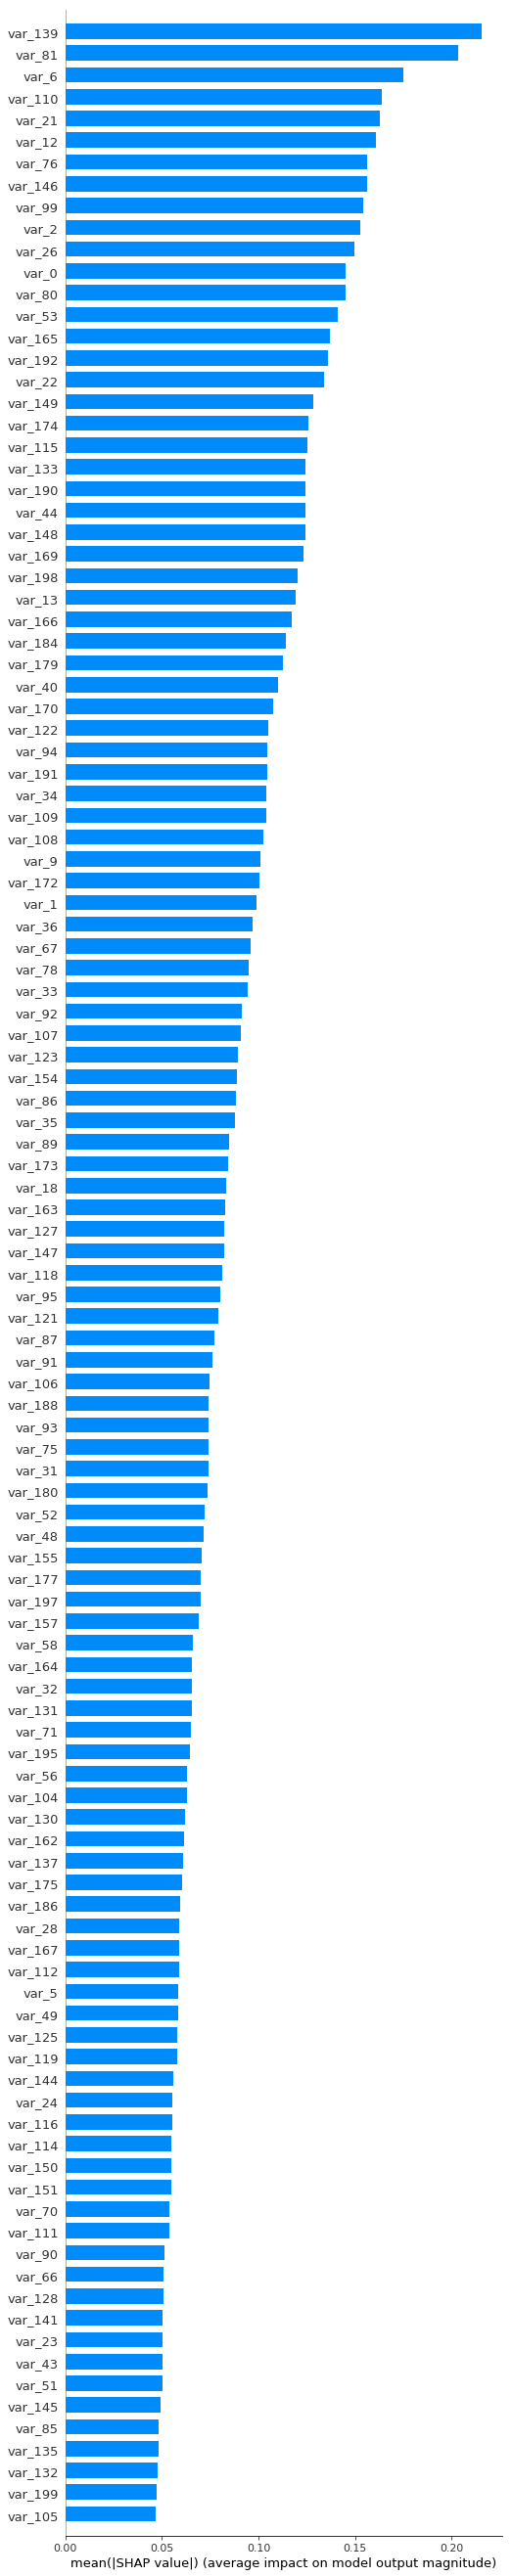

In [11]:
shap.summary_plot(shap_values, val_X,max_display=val_X.shape[0], plot_type='bar')

In [12]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([val_X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
77,var_139,0.21548
39,var_81,0.203322
4,var_6,0.174817
57,var_110,0.163934
9,var_21,0.162677
6,var_12,0.160881
36,var_76,0.156447
81,var_146,0.156384
50,var_99,0.154117
2,var_2,0.152883


In [148]:
importance_df[importance_df['shap_importance'] < 0.0231284]['column_name'].values

array(['var_194', 'var_11', 'var_45', 'var_196', 'var_83', 'var_20',
       'var_77', 'var_134', 'var_82', 'var_102', 'var_97', 'var_187',
       'var_142', 'var_88', 'var_62', 'var_4'], dtype=object)

In [13]:
feat_importance = pd.DataFrame()


feat_importance['FEATURE'] = val_X.columns
feat_importance['BY_GAIN'] = lgb_model.feature_importance(importance_type='gain').astype('int32')
feat_importance['BY_SPLIT'] = lgb_model.feature_importance(importance_type='split').astype('int32')
feat_importance = feat_importance.sort_values(by=['BY_GAIN', 'BY_SPLIT'], ascending=False)

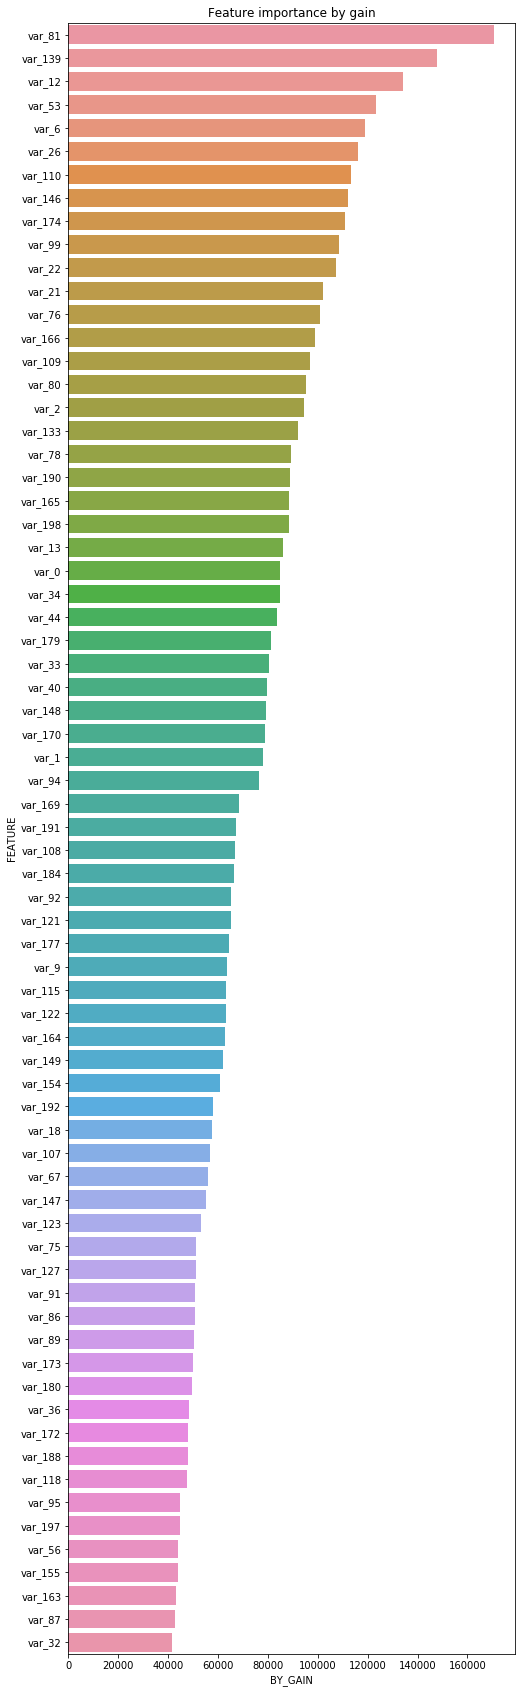

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 30))
sns.barplot(x= 'BY_GAIN', y= 'FEATURE', data= feat_importance.iloc[:70])
plt.title('Feature importance by gain')
plt.show()

/home/altieris/tools/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/altieris/tools/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


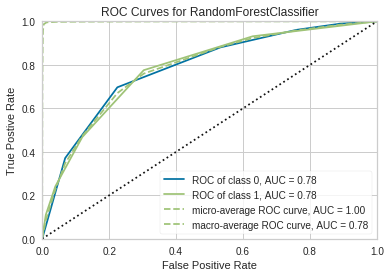

In [25]:
# from yellowbrick.classifier import ROCAUC
# from sklearn.linear_model import LogisticRegression

# classes= ['0','1']
# # Instantiate the visualizer with the classification model
# visualizer = ROCAUC(RandomForestClassifier(), classes=classes)

# model = RandomForestClassifier()
# model.fit(train_X, train_y) 
# y_test = model.predict(X_test)

# visualizer.fit(train_X, train_y)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
# https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
# https://www.kaggle.com/wrosinski/shap-feature-importance-with-feature-engineering